<center><h1 style="font-size:40px;">Project 3<br>Object detection</h1></center>

---

This project will develop an object detection system with **Single-shot multibox detectors (SSD)**. The task is to use the [COCO](https://cocodataset.org) dataset to predict bounding boxes.  

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

Good luck!

---

# Task

**TODO:** Implement **SSD** to predict bounding boxes on the training set.

**TODO:** Select a good metric to evaluate the models performance and argue why the metric give a good overview of the performance.

**TODO:** Is it possible to reduce the number of bounding boxes? If yes, implement it and why it is a good solution.


**Question:** Explain in the report what you did and why. Present a pipeline of the code. 

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [28]:
from config import LabConfig
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
import torchmetrics
import torchvision.transforms as T
from PIL import Image



import numpy as np

import zipfile

#from utils.dataset import CocoDataset
from utils.plot import Detection

In [5]:
# Run first time to unzip data folders
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [5]:
if torch.cuda.is_available():
  print("GPU available")
else:
  print("CPU")

CPU


In [267]:
# dataset_path = './input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/'
# dataset_path = './input/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/'
dataset_path = './input/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/'
train_im_path = dataset_path + 'images/train/'
train_label_path = dataset_path + 'labels/train/'

test_im_path = dataset_path + 'images/test/'
test_label_path = dataset_path + 'labels/test/'

# Only pick out imges that have labels
images = [os.path.join(dp,f,'.jpg') for dp, dn, fn in os.walk(os.path.expanduser(train_label_path[0:-4])) for f in fn if f.endswith(".txt")]

train_images = os.listdir(train_im_path)
train_labels = os.listdir(train_label_path)
test_images = os.listdir(test_im_path)
test_labels = os.listdir(test_label_path)

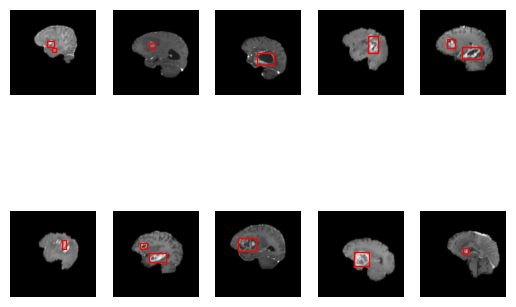

In [273]:
target_im_size = (128,128)

class Pad2Square:
    def __call__(self,image):
        max_size = max(image.size)
        pad_left,pad_top = [(max_size - s)//2 for s in image.size]
        pad_right,pad_bottom = [(max_size - (s + pad))//2 for s, pad in zip(image.size, [pad_left, pad_top])]
        pad = [pad_left, pad_top, pad_right, pad_bottom]
        print(pad)
        image = T.functional.pad(image, pad, 0, 'constant')
        return image

def pad2square(image,bb):
    max_size = max(image.size)
    pad_left,pad_top = [(max_size - s)//2 for s in image.size]
    pad_right,pad_bottom = [(max_size - (s + pad)) for s, pad in zip(image.size, [pad_left, pad_top])]
    pad = [pad_left, pad_top, pad_right, pad_bottom]
    bb[:,1] += pad_left
    bb[:,0] += pad_bottom
    image = T.functional.pad(image, pad, 0, 'constant')
    return image,bb


def plot_images_bb():
    plt.Figure(figsize=(100,20))
    n_im = 10
    # For each datapoint (image & box)
    for i, c in enumerate(np.random.randint(0, len(train_labels), size=n_im), start=1):
        ax=plt.subplot(2,5,i)
        #im = plt.imread(train_im_path+train_images[c])
        im = Image.open(train_im_path+train_labels[c][0:-4]+'.jpg')
        im_sz_y,im_sz_x = im.size 
        
    
        filename = train_label_path+train_labels[c]
        with open(filename) as f:
            lines = f.readlines()
            lines = [line.split() for line in lines]
        f.close()
        bb = np.zeros((len(lines),4))
        for l_i, line in enumerate(lines):
            # Read line, save as pixel coordinates
            line = [float(num) for num in line]
            bb_sz_x = line[4]*im_sz_x
            bb_sz_y = line[3]*im_sz_y
            bb_pos_x = line[2]*im_sz_x
            bb_pos_y = line[1]*im_sz_y
            bb[l_i,:] = [bb_pos_x,bb_pos_y,bb_sz_x,bb_sz_y]

        im, bb = pad2square(im, bb)

        # Resize bounding boxes
        im_orig_sz = im.size[0]
        resize_factor = target_im_size[0]/im_orig_sz
        bb = bb*resize_factor

        # Image transformations
        transform = T.Compose([
            T.Resize(target_im_size),
        ])

        im = transform(im)

        # Plot image and bounding box
        plt.axis('off')
        plt.imshow(im, cmap='gray')
        for b_i in range(0,l_i+1):
            # Create a Rectangle patch
            bb_sz_x = bb[b_i,2]
            bb_sz_y = bb[b_i,3]
            bb_pos_x = bb[b_i,0] - bb_sz_x/2 # center of box
            bb_pos_y = bb[b_i,1] - bb_sz_y/2 # center of box
            bb_plot = patches.Rectangle((bb_pos_y, bb_pos_x), bb_sz_y, bb_sz_x, linewidth=1, edgecolor='r', facecolor='None')
            # Add the patch to the Axes
            ax.add_patch(bb_plot)

    #plt.savefig('figures/example_sagittal.png')

plot_images_bb()        

In [54]:
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to C:\Users\nnyge08973/.cache\torch\hub\torchhub.zip
C:\Users\nnyge08973/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\nnyge08973/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nnyge08973/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.3MB/s]


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [154]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [191]:
classes_to_labels = utils.get_coco_object_dictionary()

In [226]:
#inputs = [utils.prepare_input(train_im_path+train_images[10])]
inputs = [utils.prepare_input('http://farm9.staticflickr.com/8086/8575035839_47882563af_z.jpg')]

tensor_im = utils.prepare_tensor(inputs)



In [227]:
with torch.no_grad():
    detections_batch = ssd_model(tensor_im)


In [228]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]


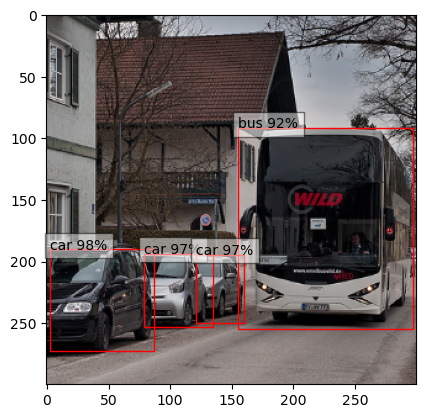

<Figure size 640x480 with 0 Axes>

In [230]:
#rom matplotlib import pyplot as plt
#import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

plt.savefig('figures/example_SSD_COCO.png')

## Load config
Note that this lab does not support for fineGrained dataset.

In [ ]:
cfg = LabConfig()
cfg.todict()

# Dataset
Coco contain a wide variety of images and the corresponding annotation. To download the dataset we use aria2 and the script found in *download.sh*. Note that the dataset is quite large so we need plenty of space on the hard drive.

Change code below to True if you want to download the data. Dont forget to change back since it will download the data each time you run the full notebook.

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [ ]:
train_transform = T.Compose([
    T.ToTensor(),
    T.SquarePad(480, 640)
])
test_transform = T.Compose([
    T.ToTensor(),
    T.SquarePad(480, 640)
])

## Dataloader

In [ ]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(
    CocoDataset(
        root=cfg.training_img_dir,
        annotation=cfg.training_annotations,
        transforms=train_transform
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collate_fn)

validation_dataloader = torch.utils.data.DataLoader(
    CocoDataset(
        root=cfg.validation_img_dir,
        annotation=cfg.validation_annotations,
        transforms=train_transform
    ),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS,
    collate_fn=collate_fn)

## Visualisations

Print the following to get an idea of the different categories

In [ ]:
cats = train_dataloader.dataset.coco.loadCats(coco_dataset.coco.getCatIds())
", ".join([cat['name'] for cat in cats])

To get an idea of what bounding boxes are we can plot a subset of the dataset. Each color represent a class which we can access through the variable *t_y*. We use colors to get an idea of different objects in order to separate them from each other.

In [ ]:
t_x, t_y = next(iter(train_dataloader))

In [ ]:
Detection.data(t_x, t_y, max(coco_dataset.coco.cats.keys()), plot_kwargs={'nimages':10}, width=5, font_size=30)

# Implementation

---